In [2]:
import numpy as np
import pandas as pd 

In [3]:
import os
for dirname, _, filenames in os.walk('tripadvisor_hotel_reviews.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!pip install -qq transformers

     |████████████████████████████████| 5.8 MB 11.4 MB/s 
     |████████████████████████████████| 182 kB 73.8 MB/s 
     |████████████████████████████████| 7.6 MB 58.9 MB/s 


In [5]:
import transformers as ppb
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [60]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [61]:
pos = [4, 5]
neg = [1, 2]
neu = [3]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1 

In [62]:
data['Sentiment'] = data['Rating'].apply(sentiment)
data.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


In [65]:
fig = go.Figure([go.Bar(x=data.Sentiment.value_counts().index, y=data.Sentiment.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [63]:
data.loc[data['Rating'] > 3, 'label'] = 1
data.loc[data['Rating'] <= 3, 'label'] = 0

data['label'].astype(int)
data = data.drop(columns = 'Rating')

batch_1 = data[:500]
batch_1['label'].value_counts()

1.0    299
0.0    201
Name: label, dtype: int64

In [16]:
model_class, token_class, pre_weights = (ppb.DistilBertModel,
                                                   ppb.DistilBertTokenizer,
                                                   'distilbert-base-uncased')
token = token_class.from_pretrained(pre_weights)
classifier = model_class.from_pretrained(pre_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
token_d = batch_1['Review'].apply((lambda x: token.encode(x, add_special_tokens = True,
                                                               truncation = True,
                                                               max_length = 250,
                                                               padding = True)))
print(token_d)

0      [101, 3835, 3309, 6450, 5581, 2288, 2204, 3066...
1      [101, 7929, 2498, 2569, 3715, 6323, 2266, 1548...
2      [101, 3835, 4734, 2025, 1018, 1008, 3325, 3309...
3      [101, 4310, 1010, 2307, 2994, 1010, 6919, 2051...
4      [101, 2307, 2994, 2307, 2994, 1010, 2253, 2712...
                             ...                        
495    [101, 21068, 3737, 3200, 6919, 3971, 5227, 603...
496    [101, 20783, 3976, 2100, 2994, 15481, 4156, 47...
497    [101, 26931, 1010, 2672, 3309, 11250, 3825, 39...
498    [101, 2307, 3199, 3309, 17463, 14326, 3446, 15...
499    [101, 5151, 20783, 26167, 2164, 4121, 2282, 44...
Name: Review, Length: 500, dtype: object


In [24]:
maximum_length = 250
for i in token_d.values:
    if len(i) > maximum_length:
        maximum_length = len(i)
        
padded = np.array([i + [0] * (maximum_length - len(i)) for i in token_d.values])
input = torch.tensor(np.array(padded))
print(input)
input.shape

tensor([[  101,  3835,  3309,  ...,     0,     0,     0],
        [  101,  7929,  2498,  ...,  2460,  9109,   102],
        [  101,  3835,  4734,  ...,  1005,  1056,   102],
        ...,
        [  101, 26931,  1010,  ...,     0,     0,     0],
        [  101,  2307,  3199,  ...,     0,     0,     0],
        [  101,  5151, 20783,  ...,     0,     0,     0]])


torch.Size([500, 250])

In [25]:
a_mask = np.where(padded != 0, 1, 0)
a_mask = torch.tensor(a_mask)
print(a_mask)
a_mask.shape

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


torch.Size([500, 250])

In [28]:
with torch.no_grad():
    last_hidden_states = classifier(input, attention_mask = a_mask, return_dict = False)

In [29]:
features = last_hidden_states[0][:, 0, :].numpy()
labels = batch_1['label']

In [30]:
features.shape

(500, 768)

In [31]:
labels.shape

(500,)

In [32]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
lr_clf.score(test_features, test_labels)

0.88

In [34]:
import missingno as msno
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
#import plotly.express as px
import matplotlib.pyplot as plt
import spacy

In [36]:
pip install en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
nlp = spacy.load('en_core_web_sm')

def normalize(msg):
    
    doc = nlp(msg)
    res = []
    
    for token in doc:
        if(token.is_stop or token.is_punct or token.is_space):
            pass
        else:
            res.append(token.lemma_.lower())
            
    return res

In [41]:
data['Review'] = data['Review'].apply(normalize)
data.head()

,Review,label
0,"[nice, hotel, expensive, parking, get, good, d...",1.0
1,"[ok, special, charge, diamond, member, hilton,...",0.0
2,"[nice, room, 4, experience, hotel, monaco, sea...",0.0
3,"[unique, great, stay, wonderful, time, hotel, ...",1.0
4,"[great, stay, great, stay, go, seahawk, game, ...",1.0


In [43]:
from collections import Counter

In [44]:
words_collection = Counter([item for sublist in data['Review'] for item in sublist])
freq_word_df = pd.DataFrame(words_collection.most_common(15))
freq_word_df.columns = ['frequently_used_word','count']

freq_word_df.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,hotel,52918
1,room,46612
2,stay,27744
3,good,21519
4,great,21283
5,staff,16375
6,night,14168
7,day,13035
8,nice,12970
9,time,12197


In [46]:
from wordcloud import WordCloud, STOPWORDS 

In [47]:
word_list = [item for sublist in data['Review'] for item in sublist]
word_string = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=60000, 
                      width=1000,
                      height=650
                         ).generate(word_string)

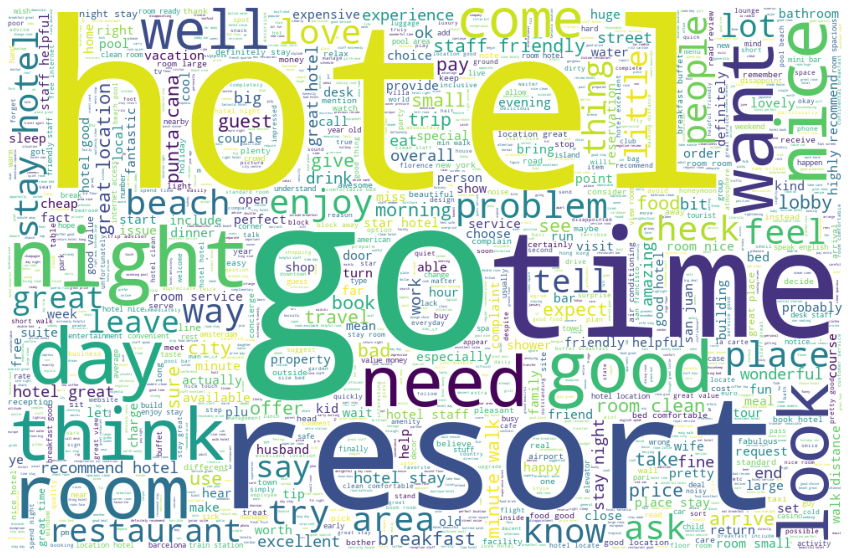

In [48]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [68]:
pos_data = data[data['Sentiment'] == 2]
words_collection = Counter([item for sublist in pos_data['Review'] for item in sublist])
freq_word_data = pd.DataFrame(words_collection.most_common(15))
freq_word_data.columns = ['frequently_used_word','count']

freq_word_data.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,,1516663
1,e,1077263
2,t,706993
3,a,697415
4,o,653795
5,r,596502
6,i,577262
7,n,558139
8,s,556823
9,l,498596


In [69]:
word_list_pos = [item for sublist in pos_data['Review'] for item in sublist]
word_string_pos = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=40000, 
                      width=1000,
                      height=650
                         ).generate(word_string_pos)

Positive Sentiment Wordcloud


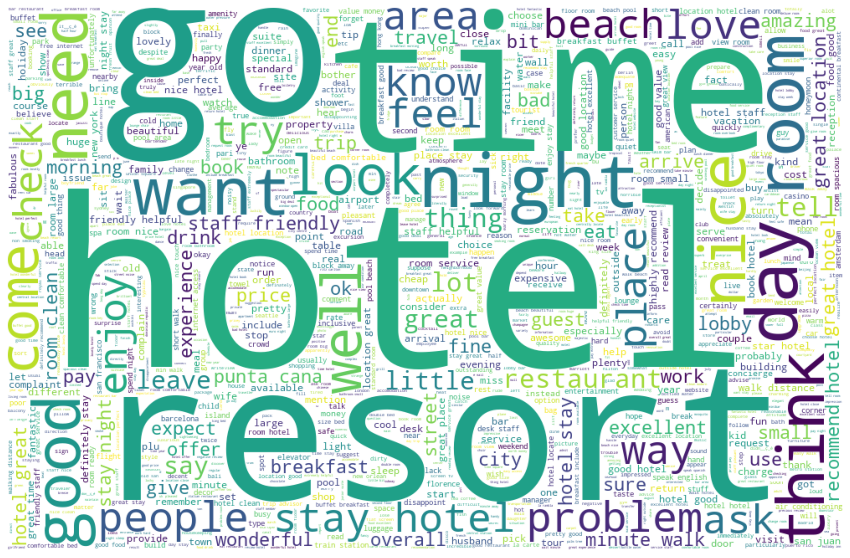

In [70]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [72]:
neg_data = data[data['Sentiment'] == 0]
words_collection = Counter([item for sublist in neg_data['Review'] for item in sublist])
freq_word_data = pd.DataFrame(words_collection.most_common(15))
freq_word_data.columns = ['frequently_used_word','count']

freq_word_data.style.background_gradient(cmap='PuBuGn', low=0, high=0, axis=0, subset=None)

,frequently_used_word,count
0,,389876
1,e,265609
2,o,176074
3,t,175082
4,a,164365
5,r,150715
6,n,148857
7,i,146142
8,s,140333
9,l,116917


In [74]:
word_list_neg = [item for sublist in neg_data['Review'] for item in sublist]
word_string_neg = " ".join(word_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=10000, 
                      width=1000,
                      height=650
                         ).generate(word_string_neg)

Negative Sentiment Wordcloud

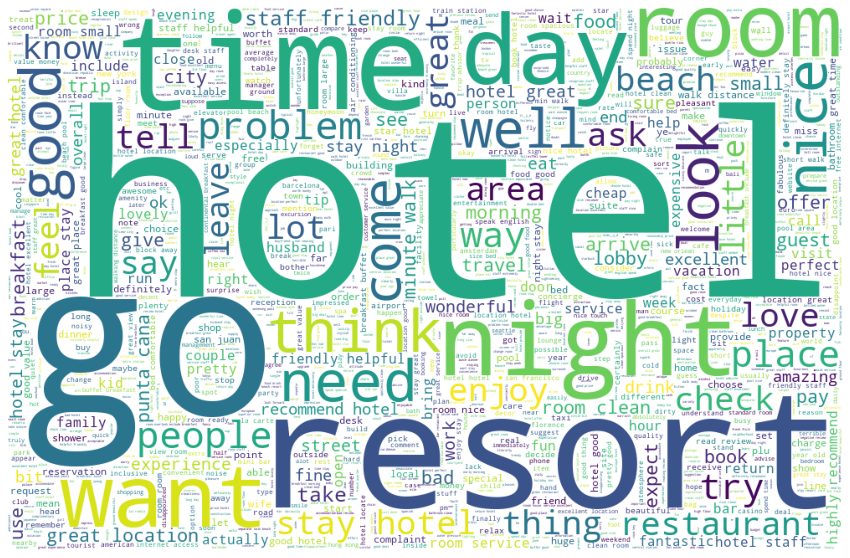

In [75]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()